In [1]:
%cd ..

/home/ec2-user/uclresearchanalysis


In [2]:
%matplotlib inline
import builtins
builtins.uclresearch_topic = 'GIVENCHY' #0 -- Finished
# builtins.uclresearch_topic = 'HAWKING' #0 -- Finished
# builtins.uclresearch_topic = 'NYC' # 88001
# builtins.uclresearch_topic = 'FLORIDA' # 448387
from configuration import config
from configuration.config import load_ml_data
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from pandas import *
import pandas as pd
from pprint import pprint
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

import pickle
import shap

import multiprocessing
cpu_count = multiprocessing.cpu_count()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

('Reading config file from location: '
 '/home/ec2-user/uclresearchanalysis/configuration/env.properties')
{'calculate': {'analysis': True,
               'network': True,
               'uniquetweets': True,
               'uniqueusers': True},
 'data': {'dates': ['2018-03-11', '2018-03-12', '2018-03-13'],
          'eventname': "Givenchy's Death",
          'phrases': ['givenchy%20death', 'givenchy%20passed%20away'],
          'starttime': 'Mar 12 08:20:00 -0500 2018'},
 'path': {'crawl': {'followers': '/home/ec2-user/uclresearchanalysis/followers',
                    'friends': '/home/ec2-user/uclresearchanalysis/friends'},
          'cwd': '/home/ec2-user/uclresearchanalysis/data/givenchy',
          'ml': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle',
          'networkx': {'all': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle/networkx_all.dat',
                       'friends': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle/networkx_friends.dat',


In [3]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
# Parameters
interval = 30

# 1. Prepare
def prepare_data(interval):
    df = load_ml_data(interval)
    df = df.reset_index(drop=True)
    
    # Converting all type to float, to prepare for feature selection
    df = df.astype('float')
    # Reset index, with drop equals to true to avoid setting old index as a new column
    df = df.reset_index(drop=True)
    # Visualize distribution
    print('[Original] data counts, with uninfected (0): {}, infected (1): {}'.format(
        df['label'].value_counts()[0],
        df['label'].value_counts()[1]
    ))
    df.groupby(['TwM_tCurrent','label']).size().unstack(fill_value=0).plot.bar(title='Original Data Distribution')
    
    columns = list(df.columns)
    columns.remove('label')
    
    X = df[columns]
    y = df[['label']]
    return df, X, y


Loading data file from path /home/ec2-user/uclresearchanalysis/data/givenchy/pickle/30_data.dat
'Loaded 55559 entires'
[Original] data counts, with uninfected (0): 45777, infected (1): 9782


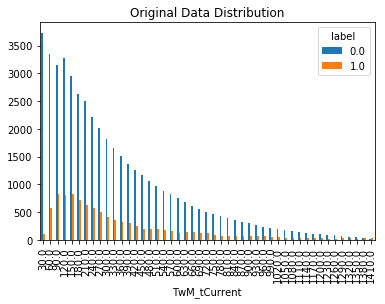

In [5]:
# 1. Prepare
df, X, y = prepare_data(interval)

In [6]:
feature_columns = X.columns
print('There are {} Features'.format(len(feature_columns)))

There are 88 Features


In [7]:
def upsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    print(df_upsampled.label.value_counts())
    
    return df_upsampled

In [8]:
def downsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=len(df_minority),     # to match minority class
                                     random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    # Display new class counts
    print(df_downsampled.label.value_counts())
    
    return df_downsampled

In [9]:
def train(df, X, y, params, n_folds, num_boost_round, rebalance_method):
    # 2. N Fold Split
    # Stratified K-Folds cross-validator
    # Provides train/test indices to split data in train/test sets. 
    # This cross-validation object is a variation of KFold that returns stratified folds. 
    # The folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    corrDataframe = pd.DataFrame()    
    mse = []
    acc = []
    roc = []
    F1 = []
    auc = []
    auc_t = []
    acc_t = []
    fold_count = 0
    t_current = 210
    number_of_features = len(X.columns)

    print("Start cross validation")
    for train, test in skf.split(X, y):
        print("===Processing fold %s===" % fold_count)
        train_fold = df.loc[train]
        test_fold = df.loc[test]

        # 3. Rebalance
        if rebalance_method == 'up':
            train_fold = upsample(train_fold)
        if rebalance_method == 'down':
            train_fold = downsample(train_fold)
         
        # 4. Feature Selection
#         corr = train_fold.corr()['label'][train_fold.corr()['label'] < 1].abs()
#         corr = corr.sort_values(ascending=False)
#         corrDataframe = corrDataframe.append(pd.DataFrame(corr.rename('cv{}'.format(fold_count))).T)
#         features = corr.index[range(number_of_features)].values
        features = X.columns
        
        # 5. Training
        # Fit Model
        xgtrain = xgb.DMatrix(train_fold[features].values, train_fold['label'].values)
        xgtest = xgb.DMatrix(test_fold[features].values, test_fold['label'].values)
#         evallist = [(xgtrain, 'train'),(xgtest,'eval')]
        evallist = []
        
        bst = xgb.train(params, xgtrain, 
                        num_boost_round = num_boost_round, 
                        evals = evallist)

        # 6. Testing
        # Check MSE on test set
        
        test_fold_t = test_fold[test_fold.TwM_tCurrent == t_current]
#             xgtest = xgb.DMatrix(test_fold[features].values)
        xgtest_t = xgb.DMatrix(test_fold_t[features].values)
        pred = bst.predict(xgtest)
        pred_t = bst.predict(xgtest_t)

        mse.append(mean_squared_error(test_fold['label'], pred))
        roc.append(roc_auc_score(test_fold['label'], pred))
        auc_t.append(roc_auc_score(test_fold_t['label'], pred_t))

        acc.append(accuracy_score(test_fold['label'], (pred>0.5).astype(int)))
        acc_t.append(accuracy_score(test_fold_t['label'], (pred_t>0.5).astype(int)))
        F1.append(f1_score(test_fold['label'],(pred>0.5).astype(int)))
        cm = confusion_matrix(test_fold['label'], (pred>0.5).astype(int))
        plot_confusion_matrix(cm, 
                              normalize    = True,
                              target_names = ['Uninfected', 'Infected'],
                              title        = "Confusion Matrix, Normalized")


        fold_count += 1
        # Done with the fold
    print("Finished cross validation")
    print("MSE: {} ".format(DataFrame(mse).mean()))
    print("ACC: {} ".format(DataFrame(acc).mean()))
    print("AUC: {} ".format(DataFrame(roc).mean()))
#     print("F1: {} ".format(DataFrame(F1).mean()))
    print("ACC for t at {}: {} ".format(t_current, DataFrame(acc_t).mean()))
    corrDataframe = corrDataframe.T
    corrDataframe['average corr'] = corrDataframe.mean(numeric_only=True, axis=1)
    print(corrDataframe.sort_values(by=['average corr'], ascending=False).to_string())

    return bst


In [10]:
#xgboost
param = {
    'max_depth':3,
    # Step size shrinkage used in update to prevents overfitting. 
    # After each boosting step, we can directly get the weights of new features, 
    # and eta shrinks the feature weights to make the boosting process more conservative.
    'eta': 0.001,
    # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
    # The larger gamma is, the more conservative the algorithm will be.
    'gamma':10,
    # Minimum sum of instance weight (hessian) needed in a child. 
    # If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, 
    # then the building process will give up further partitioning.
    # The larger min_child_weight is, the more conservative the algorithm will be.
    'min_child_weight':10,
    'silent': 1, # 0 means printing running messages, 1 means silent mode
    'objective': 'binary:logistic',
    'subsample': 0.9
}
param['nthread'] = cpu_count
param['eval_metric'] = ['auc']
num_boost_round = 40000
rebalance_method = 'up'

In [11]:
xgb_model = train(df, X, y, param, 2, num_boost_round, rebalance_method)

Start cross validation
===Processing fold 0===
1.0    22888
0.0    22888
Name: label, dtype: int64
[0]	train-auc:0.615229	eval-auc:0.610493
[1]	train-auc:0.615181	eval-auc:0.61075
[2]	train-auc:0.618016	eval-auc:0.61299
[3]	train-auc:0.619208	eval-auc:0.61435
[4]	train-auc:0.627054	eval-auc:0.620663
[5]	train-auc:0.627371	eval-auc:0.621099
[6]	train-auc:0.627447	eval-auc:0.62111
[7]	train-auc:0.627236	eval-auc:0.620971
[8]	train-auc:0.627209	eval-auc:0.621067
[9]	train-auc:0.627241	eval-auc:0.621086
[10]	train-auc:0.627206	eval-auc:0.621078
[11]	train-auc:0.627156	eval-auc:0.621081
[12]	train-auc:0.627178	eval-auc:0.621086
[13]	train-auc:0.627157	eval-auc:0.621051
[14]	train-auc:0.62718	eval-auc:0.621045
[15]	train-auc:0.627206	eval-auc:0.621087
[16]	train-auc:0.623557	eval-auc:0.618285
[17]	train-auc:0.623522	eval-auc:0.618203
[18]	train-auc:0.623565	eval-auc:0.618253
[19]	train-auc:0.623549	eval-auc:0.618242
[20]	train-auc:0.623543	eval-auc:0.618237
[21]	train-auc:0.623548	eval-auc:0

[193]	train-auc:0.631796	eval-auc:0.624459
[194]	train-auc:0.631742	eval-auc:0.624503
[195]	train-auc:0.631771	eval-auc:0.624515
[196]	train-auc:0.631765	eval-auc:0.62452
[197]	train-auc:0.631788	eval-auc:0.624575
[198]	train-auc:0.631781	eval-auc:0.624564
[199]	train-auc:0.631844	eval-auc:0.624628
[200]	train-auc:0.632426	eval-auc:0.624745
[201]	train-auc:0.632427	eval-auc:0.624752
[202]	train-auc:0.632427	eval-auc:0.624746
[203]	train-auc:0.632441	eval-auc:0.624775
[204]	train-auc:0.632445	eval-auc:0.624768
[205]	train-auc:0.632455	eval-auc:0.624758
[206]	train-auc:0.632452	eval-auc:0.624765
[207]	train-auc:0.632446	eval-auc:0.624766
[208]	train-auc:0.632457	eval-auc:0.624781
[209]	train-auc:0.632457	eval-auc:0.624783
[210]	train-auc:0.632444	eval-auc:0.624774
[211]	train-auc:0.632784	eval-auc:0.624976
[212]	train-auc:0.632813	eval-auc:0.624954
[213]	train-auc:0.632577	eval-auc:0.624674
[214]	train-auc:0.632603	eval-auc:0.62468
[215]	train-auc:0.632604	eval-auc:0.624679
[216]	train-a

[385]	train-auc:0.634871	eval-auc:0.62676
[386]	train-auc:0.634884	eval-auc:0.626764
[387]	train-auc:0.634883	eval-auc:0.626747
[388]	train-auc:0.63502	eval-auc:0.626795
[389]	train-auc:0.635017	eval-auc:0.62675
[390]	train-auc:0.635081	eval-auc:0.626767
[391]	train-auc:0.635081	eval-auc:0.62674
[392]	train-auc:0.635051	eval-auc:0.626666
[393]	train-auc:0.63506	eval-auc:0.626729
[394]	train-auc:0.635071	eval-auc:0.626763
[395]	train-auc:0.635091	eval-auc:0.626788
[396]	train-auc:0.635095	eval-auc:0.626807
[397]	train-auc:0.635179	eval-auc:0.626905
[398]	train-auc:0.635181	eval-auc:0.626904
[399]	train-auc:0.635221	eval-auc:0.626913
[400]	train-auc:0.635223	eval-auc:0.626915
[401]	train-auc:0.635195	eval-auc:0.626907
[402]	train-auc:0.635192	eval-auc:0.626906
[403]	train-auc:0.635193	eval-auc:0.626925
[404]	train-auc:0.635227	eval-auc:0.626916
[405]	train-auc:0.635239	eval-auc:0.62689
[406]	train-auc:0.635274	eval-auc:0.626894
[407]	train-auc:0.635262	eval-auc:0.626893
[408]	train-auc:0

[577]	train-auc:0.637067	eval-auc:0.627681
[578]	train-auc:0.637076	eval-auc:0.627689
[579]	train-auc:0.637101	eval-auc:0.627723
[580]	train-auc:0.637106	eval-auc:0.627717
[581]	train-auc:0.637112	eval-auc:0.627714
[582]	train-auc:0.637095	eval-auc:0.627698
[583]	train-auc:0.637325	eval-auc:0.627766
[584]	train-auc:0.637325	eval-auc:0.627761
[585]	train-auc:0.63731	eval-auc:0.627754
[586]	train-auc:0.637285	eval-auc:0.62773
[587]	train-auc:0.637281	eval-auc:0.627727
[588]	train-auc:0.637281	eval-auc:0.62773
[589]	train-auc:0.637315	eval-auc:0.627763
[590]	train-auc:0.637317	eval-auc:0.627754
[591]	train-auc:0.637381	eval-auc:0.627783
[592]	train-auc:0.637429	eval-auc:0.627834
[593]	train-auc:0.637425	eval-auc:0.627832
[594]	train-auc:0.637401	eval-auc:0.627824
[595]	train-auc:0.637377	eval-auc:0.627794
[596]	train-auc:0.637402	eval-auc:0.627789
[597]	train-auc:0.637398	eval-auc:0.627799
[598]	train-auc:0.637447	eval-auc:0.627828
[599]	train-auc:0.637437	eval-auc:0.627826
[600]	train-au

[769]	train-auc:0.640388	eval-auc:0.628601
[770]	train-auc:0.640381	eval-auc:0.62858
[771]	train-auc:0.6404	eval-auc:0.628579
[772]	train-auc:0.640378	eval-auc:0.628587
[773]	train-auc:0.64044	eval-auc:0.628599
[774]	train-auc:0.640429	eval-auc:0.628593
[775]	train-auc:0.64041	eval-auc:0.628593
[776]	train-auc:0.640392	eval-auc:0.628586
[777]	train-auc:0.640906	eval-auc:0.629147
[778]	train-auc:0.640923	eval-auc:0.629169
[779]	train-auc:0.640934	eval-auc:0.629155
[780]	train-auc:0.640928	eval-auc:0.629132
[781]	train-auc:0.640918	eval-auc:0.629142
[782]	train-auc:0.640908	eval-auc:0.62915
[783]	train-auc:0.640895	eval-auc:0.629168
[784]	train-auc:0.640923	eval-auc:0.629161
[785]	train-auc:0.640992	eval-auc:0.629223
[786]	train-auc:0.640988	eval-auc:0.629228
[787]	train-auc:0.64101	eval-auc:0.629227
[788]	train-auc:0.641043	eval-auc:0.629255
[789]	train-auc:0.641039	eval-auc:0.629251
[790]	train-auc:0.641047	eval-auc:0.629266
[791]	train-auc:0.641049	eval-auc:0.629264
[792]	train-auc:0.

[961]	train-auc:0.644157	eval-auc:0.63112
[962]	train-auc:0.644157	eval-auc:0.631103
[963]	train-auc:0.644235	eval-auc:0.631073
[964]	train-auc:0.644246	eval-auc:0.631077
[965]	train-auc:0.644245	eval-auc:0.631104
[966]	train-auc:0.644254	eval-auc:0.631124
[967]	train-auc:0.644257	eval-auc:0.631109
[968]	train-auc:0.644283	eval-auc:0.63111
[969]	train-auc:0.644287	eval-auc:0.63112
[970]	train-auc:0.644286	eval-auc:0.63114
[971]	train-auc:0.644335	eval-auc:0.631174
[972]	train-auc:0.644352	eval-auc:0.631197
[973]	train-auc:0.644465	eval-auc:0.631263
[974]	train-auc:0.644505	eval-auc:0.631279
[975]	train-auc:0.644525	eval-auc:0.631259
[976]	train-auc:0.644597	eval-auc:0.63131
[977]	train-auc:0.644612	eval-auc:0.631319
[978]	train-auc:0.64464	eval-auc:0.631326
[979]	train-auc:0.644656	eval-auc:0.631313
[980]	train-auc:0.64465	eval-auc:0.631319
[981]	train-auc:0.64467	eval-auc:0.631359
[982]	train-auc:0.644698	eval-auc:0.631355
[983]	train-auc:0.644699	eval-auc:0.63137
[984]	train-auc:0.64

[1149]	train-auc:0.64867	eval-auc:0.633311
[1150]	train-auc:0.648673	eval-auc:0.633328
[1151]	train-auc:0.648687	eval-auc:0.633304
[1152]	train-auc:0.64869	eval-auc:0.633334
[1153]	train-auc:0.648726	eval-auc:0.633377
[1154]	train-auc:0.648728	eval-auc:0.633414
[1155]	train-auc:0.64873	eval-auc:0.633388
[1156]	train-auc:0.648735	eval-auc:0.633413
[1157]	train-auc:0.648722	eval-auc:0.63346
[1158]	train-auc:0.648762	eval-auc:0.633518
[1159]	train-auc:0.648753	eval-auc:0.633496
[1160]	train-auc:0.648742	eval-auc:0.633468
[1161]	train-auc:0.648768	eval-auc:0.633477
[1162]	train-auc:0.648795	eval-auc:0.633474
[1163]	train-auc:0.648832	eval-auc:0.633488
[1164]	train-auc:0.648854	eval-auc:0.63351
[1165]	train-auc:0.648839	eval-auc:0.633504
[1166]	train-auc:0.648865	eval-auc:0.633516
[1167]	train-auc:0.648891	eval-auc:0.633483
[1168]	train-auc:0.648954	eval-auc:0.633521
[1169]	train-auc:0.649056	eval-auc:0.633604
[1170]	train-auc:0.649072	eval-auc:0.633617
[1171]	train-auc:0.649071	eval-auc:0.

[1337]	train-auc:0.651022	eval-auc:0.634906
[1338]	train-auc:0.651022	eval-auc:0.634931
[1339]	train-auc:0.650987	eval-auc:0.63491
[1340]	train-auc:0.651011	eval-auc:0.634914
[1341]	train-auc:0.651018	eval-auc:0.634913
[1342]	train-auc:0.651027	eval-auc:0.634914
[1343]	train-auc:0.651028	eval-auc:0.634888
[1344]	train-auc:0.651047	eval-auc:0.634895
[1345]	train-auc:0.651049	eval-auc:0.634904
[1346]	train-auc:0.651084	eval-auc:0.634917
[1347]	train-auc:0.651072	eval-auc:0.634898
[1348]	train-auc:0.651078	eval-auc:0.634907
[1349]	train-auc:0.651088	eval-auc:0.634917
[1350]	train-auc:0.651109	eval-auc:0.63499
[1351]	train-auc:0.651098	eval-auc:0.634997
[1352]	train-auc:0.651099	eval-auc:0.635004
[1353]	train-auc:0.651088	eval-auc:0.635001
[1354]	train-auc:0.651076	eval-auc:0.635015
[1355]	train-auc:0.651135	eval-auc:0.635019
[1356]	train-auc:0.651145	eval-auc:0.635049
[1357]	train-auc:0.651143	eval-auc:0.635033
[1358]	train-auc:0.65116	eval-auc:0.635029
[1359]	train-auc:0.651155	eval-auc:

[1524]	train-auc:0.65342	eval-auc:0.636197
[1525]	train-auc:0.653438	eval-auc:0.636213
[1526]	train-auc:0.653452	eval-auc:0.636215
[1527]	train-auc:0.653465	eval-auc:0.636225
[1528]	train-auc:0.653489	eval-auc:0.636232
[1529]	train-auc:0.653511	eval-auc:0.63624
[1530]	train-auc:0.653534	eval-auc:0.63626
[1531]	train-auc:0.653534	eval-auc:0.636256
[1532]	train-auc:0.653547	eval-auc:0.636278
[1533]	train-auc:0.653555	eval-auc:0.636286
[1534]	train-auc:0.653569	eval-auc:0.636284
[1535]	train-auc:0.65357	eval-auc:0.636283
[1536]	train-auc:0.653596	eval-auc:0.636303
[1537]	train-auc:0.653603	eval-auc:0.636319
[1538]	train-auc:0.653606	eval-auc:0.636322
[1539]	train-auc:0.653626	eval-auc:0.636338
[1540]	train-auc:0.653643	eval-auc:0.636341
[1541]	train-auc:0.653659	eval-auc:0.636363
[1542]	train-auc:0.653679	eval-auc:0.63635
[1543]	train-auc:0.653689	eval-auc:0.636339
[1544]	train-auc:0.653714	eval-auc:0.636345
[1545]	train-auc:0.653723	eval-auc:0.636359
[1546]	train-auc:0.653727	eval-auc:0.

[1712]	train-auc:0.656328	eval-auc:0.637932
[1713]	train-auc:0.65633	eval-auc:0.637947
[1714]	train-auc:0.656346	eval-auc:0.637954
[1715]	train-auc:0.656356	eval-auc:0.637958
[1716]	train-auc:0.656369	eval-auc:0.637961
[1717]	train-auc:0.656376	eval-auc:0.637979
[1718]	train-auc:0.656392	eval-auc:0.637984
[1719]	train-auc:0.656402	eval-auc:0.637993
[1720]	train-auc:0.65642	eval-auc:0.638015
[1721]	train-auc:0.65643	eval-auc:0.638029
[1722]	train-auc:0.656446	eval-auc:0.638021
[1723]	train-auc:0.656459	eval-auc:0.638041
[1724]	train-auc:0.656472	eval-auc:0.638061
[1725]	train-auc:0.656489	eval-auc:0.638064
[1726]	train-auc:0.656507	eval-auc:0.638088
[1727]	train-auc:0.656522	eval-auc:0.638077
[1728]	train-auc:0.656532	eval-auc:0.638084
[1729]	train-auc:0.656525	eval-auc:0.638088
[1730]	train-auc:0.656538	eval-auc:0.638105
[1731]	train-auc:0.656552	eval-auc:0.638114
[1732]	train-auc:0.656545	eval-auc:0.638129
[1733]	train-auc:0.656559	eval-auc:0.638131
[1734]	train-auc:0.656561	eval-auc:

[1899]	train-auc:0.658388	eval-auc:0.639208
[1900]	train-auc:0.658401	eval-auc:0.639209
[1901]	train-auc:0.658412	eval-auc:0.639204
[1902]	train-auc:0.658415	eval-auc:0.639218
[1903]	train-auc:0.65843	eval-auc:0.639229
[1904]	train-auc:0.658446	eval-auc:0.639235
[1905]	train-auc:0.658467	eval-auc:0.639253
[1906]	train-auc:0.658465	eval-auc:0.639259
[1907]	train-auc:0.658474	eval-auc:0.639258
[1908]	train-auc:0.658488	eval-auc:0.639272
[1909]	train-auc:0.658503	eval-auc:0.639284
[1910]	train-auc:0.658515	eval-auc:0.639285
[1911]	train-auc:0.658526	eval-auc:0.639287
[1912]	train-auc:0.658543	eval-auc:0.639295
[1913]	train-auc:0.658547	eval-auc:0.639291
[1914]	train-auc:0.658563	eval-auc:0.63929
[1915]	train-auc:0.658575	eval-auc:0.639292
[1916]	train-auc:0.658572	eval-auc:0.639295
[1917]	train-auc:0.658595	eval-auc:0.639295
[1918]	train-auc:0.658606	eval-auc:0.639301
[1919]	train-auc:0.658608	eval-auc:0.639309
[1920]	train-auc:0.658625	eval-auc:0.639327
[1921]	train-auc:0.658635	eval-auc

[2087]	train-auc:0.660251	eval-auc:0.640109
[2088]	train-auc:0.660264	eval-auc:0.640117
[2089]	train-auc:0.66028	eval-auc:0.640112
[2090]	train-auc:0.660291	eval-auc:0.640135
[2091]	train-auc:0.660306	eval-auc:0.640144
[2092]	train-auc:0.660323	eval-auc:0.640162
[2093]	train-auc:0.660331	eval-auc:0.640163
[2094]	train-auc:0.660336	eval-auc:0.640156
[2095]	train-auc:0.660345	eval-auc:0.640164
[2096]	train-auc:0.660363	eval-auc:0.640158
[2097]	train-auc:0.660372	eval-auc:0.640171
[2098]	train-auc:0.660396	eval-auc:0.640199
[2099]	train-auc:0.660418	eval-auc:0.640216
[2100]	train-auc:0.660429	eval-auc:0.640219
[2101]	train-auc:0.660436	eval-auc:0.640214
[2102]	train-auc:0.660435	eval-auc:0.640203
[2103]	train-auc:0.66046	eval-auc:0.640239
[2104]	train-auc:0.66047	eval-auc:0.64023
[2105]	train-auc:0.660469	eval-auc:0.640221
[2106]	train-auc:0.660484	eval-auc:0.640235
[2107]	train-auc:0.660495	eval-auc:0.640241
[2108]	train-auc:0.660509	eval-auc:0.640251
[2109]	train-auc:0.660513	eval-auc:0

[2274]	train-auc:0.662496	eval-auc:0.641181
[2275]	train-auc:0.662517	eval-auc:0.64119
[2276]	train-auc:0.662532	eval-auc:0.641196
[2277]	train-auc:0.662548	eval-auc:0.641204
[2278]	train-auc:0.662549	eval-auc:0.641212
[2279]	train-auc:0.662558	eval-auc:0.641211
[2280]	train-auc:0.66258	eval-auc:0.641215
[2281]	train-auc:0.662593	eval-auc:0.641222
[2282]	train-auc:0.662616	eval-auc:0.64122
[2283]	train-auc:0.662632	eval-auc:0.641224
[2284]	train-auc:0.662643	eval-auc:0.641227
[2285]	train-auc:0.662657	eval-auc:0.641226
[2286]	train-auc:0.662665	eval-auc:0.64123
[2287]	train-auc:0.66268	eval-auc:0.641237
[2288]	train-auc:0.662695	eval-auc:0.641238
[2289]	train-auc:0.662705	eval-auc:0.641245
[2290]	train-auc:0.662718	eval-auc:0.641256
[2291]	train-auc:0.662722	eval-auc:0.641257
[2292]	train-auc:0.662725	eval-auc:0.641269
[2293]	train-auc:0.662737	eval-auc:0.64128
[2294]	train-auc:0.662748	eval-auc:0.641289
[2295]	train-auc:0.662764	eval-auc:0.641298
[2296]	train-auc:0.662773	eval-auc:0.6

[2462]	train-auc:0.664708	eval-auc:0.642
[2463]	train-auc:0.664708	eval-auc:0.642004
[2464]	train-auc:0.66472	eval-auc:0.642005
[2465]	train-auc:0.664728	eval-auc:0.642008
[2466]	train-auc:0.664732	eval-auc:0.642013
[2467]	train-auc:0.664749	eval-auc:0.642011
[2468]	train-auc:0.664762	eval-auc:0.64202
[2469]	train-auc:0.664781	eval-auc:0.642028
[2470]	train-auc:0.664808	eval-auc:0.642031
[2471]	train-auc:0.664807	eval-auc:0.642033
[2472]	train-auc:0.664819	eval-auc:0.64204
[2473]	train-auc:0.664842	eval-auc:0.64205
[2474]	train-auc:0.66486	eval-auc:0.642058
[2475]	train-auc:0.664867	eval-auc:0.642066
[2476]	train-auc:0.664878	eval-auc:0.64207
[2477]	train-auc:0.664904	eval-auc:0.642076
[2478]	train-auc:0.664915	eval-auc:0.642081
[2479]	train-auc:0.664927	eval-auc:0.642093
[2480]	train-auc:0.664934	eval-auc:0.642094
[2481]	train-auc:0.664943	eval-auc:0.642097
[2482]	train-auc:0.664955	eval-auc:0.642101
[2483]	train-auc:0.664962	eval-auc:0.642098
[2484]	train-auc:0.664971	eval-auc:0.6420

[2650]	train-auc:0.666766	eval-auc:0.642963
[2651]	train-auc:0.666776	eval-auc:0.642964
[2652]	train-auc:0.666782	eval-auc:0.642968
[2653]	train-auc:0.666803	eval-auc:0.642965
[2654]	train-auc:0.666802	eval-auc:0.642965
[2655]	train-auc:0.666811	eval-auc:0.642968
[2656]	train-auc:0.666823	eval-auc:0.642975
[2657]	train-auc:0.666848	eval-auc:0.642974
[2658]	train-auc:0.666868	eval-auc:0.642974
[2659]	train-auc:0.666879	eval-auc:0.642974
[2660]	train-auc:0.666891	eval-auc:0.642976
[2661]	train-auc:0.66691	eval-auc:0.642984
[2662]	train-auc:0.666918	eval-auc:0.642988
[2663]	train-auc:0.666923	eval-auc:0.642986
[2664]	train-auc:0.666942	eval-auc:0.642991
[2665]	train-auc:0.666955	eval-auc:0.642989
[2666]	train-auc:0.666973	eval-auc:0.642993
[2667]	train-auc:0.666979	eval-auc:0.643
[2668]	train-auc:0.666986	eval-auc:0.643005
[2669]	train-auc:0.667019	eval-auc:0.643021
[2670]	train-auc:0.667031	eval-auc:0.643032
[2671]	train-auc:0.667038	eval-auc:0.643038
[2672]	train-auc:0.667046	eval-auc:0

[2837]	train-auc:0.668889	eval-auc:0.643585
[2838]	train-auc:0.668917	eval-auc:0.643595
[2839]	train-auc:0.668924	eval-auc:0.643594
[2840]	train-auc:0.668928	eval-auc:0.643598
[2841]	train-auc:0.668944	eval-auc:0.643601
[2842]	train-auc:0.668951	eval-auc:0.643604
[2843]	train-auc:0.668966	eval-auc:0.643607
[2844]	train-auc:0.66899	eval-auc:0.643616
[2845]	train-auc:0.668998	eval-auc:0.643614
[2846]	train-auc:0.669005	eval-auc:0.643618
[2847]	train-auc:0.669008	eval-auc:0.643614
[2848]	train-auc:0.66903	eval-auc:0.643625
[2849]	train-auc:0.669045	eval-auc:0.64363
[2850]	train-auc:0.669053	eval-auc:0.643632
[2851]	train-auc:0.669073	eval-auc:0.643631
[2852]	train-auc:0.669083	eval-auc:0.643636
[2853]	train-auc:0.669084	eval-auc:0.64364
[2854]	train-auc:0.669103	eval-auc:0.643639
[2855]	train-auc:0.669112	eval-auc:0.643637
[2856]	train-auc:0.669125	eval-auc:0.643636
[2857]	train-auc:0.669131	eval-auc:0.643638
[2858]	train-auc:0.669144	eval-auc:0.643646
[2859]	train-auc:0.669156	eval-auc:0

[3025]	train-auc:0.670997	eval-auc:0.644136
[3026]	train-auc:0.671014	eval-auc:0.644142
[3027]	train-auc:0.671016	eval-auc:0.64414
[3028]	train-auc:0.671021	eval-auc:0.644144
[3029]	train-auc:0.671032	eval-auc:0.64415
[3030]	train-auc:0.671041	eval-auc:0.644157
[3031]	train-auc:0.671048	eval-auc:0.644159
[3032]	train-auc:0.671059	eval-auc:0.644163
[3033]	train-auc:0.671078	eval-auc:0.644169
[3034]	train-auc:0.671093	eval-auc:0.644173
[3035]	train-auc:0.671098	eval-auc:0.644179
[3036]	train-auc:0.671104	eval-auc:0.644177
[3037]	train-auc:0.671108	eval-auc:0.644186
[3038]	train-auc:0.671126	eval-auc:0.644192
[3039]	train-auc:0.671137	eval-auc:0.644198
[3040]	train-auc:0.671148	eval-auc:0.644196
[3041]	train-auc:0.671151	eval-auc:0.644195
[3042]	train-auc:0.671167	eval-auc:0.644198
[3043]	train-auc:0.671173	eval-auc:0.644197
[3044]	train-auc:0.671178	eval-auc:0.644196
[3045]	train-auc:0.671182	eval-auc:0.644198
[3046]	train-auc:0.671197	eval-auc:0.644196
[3047]	train-auc:0.671212	eval-auc

[3213]	train-auc:0.672887	eval-auc:0.644613
[3214]	train-auc:0.672902	eval-auc:0.644623
[3215]	train-auc:0.67292	eval-auc:0.644624
[3216]	train-auc:0.672924	eval-auc:0.644626
[3217]	train-auc:0.672926	eval-auc:0.644628
[3218]	train-auc:0.672932	eval-auc:0.64463
[3219]	train-auc:0.672939	eval-auc:0.644632
[3220]	train-auc:0.672951	eval-auc:0.644635
[3221]	train-auc:0.672957	eval-auc:0.644638
[3222]	train-auc:0.672965	eval-auc:0.644641
[3223]	train-auc:0.67297	eval-auc:0.644641
[3224]	train-auc:0.672981	eval-auc:0.644641
[3225]	train-auc:0.672991	eval-auc:0.644649
[3226]	train-auc:0.673003	eval-auc:0.644654
[3227]	train-auc:0.673013	eval-auc:0.644656
[3228]	train-auc:0.673026	eval-auc:0.644661
[3229]	train-auc:0.673044	eval-auc:0.644665
[3230]	train-auc:0.673053	eval-auc:0.644665
[3231]	train-auc:0.673066	eval-auc:0.644662
[3232]	train-auc:0.673078	eval-auc:0.644668
[3233]	train-auc:0.67309	eval-auc:0.644675
[3234]	train-auc:0.673097	eval-auc:0.644675
[3235]	train-auc:0.673103	eval-auc:0

[3401]	train-auc:0.674776	eval-auc:0.645067
[3402]	train-auc:0.674777	eval-auc:0.645075
[3403]	train-auc:0.674801	eval-auc:0.645081
[3404]	train-auc:0.674809	eval-auc:0.645081
[3405]	train-auc:0.674811	eval-auc:0.645082
[3406]	train-auc:0.674821	eval-auc:0.645082
[3407]	train-auc:0.674824	eval-auc:0.645085
[3408]	train-auc:0.674835	eval-auc:0.645087
[3409]	train-auc:0.674847	eval-auc:0.645091
[3410]	train-auc:0.674857	eval-auc:0.645094
[3411]	train-auc:0.674872	eval-auc:0.645098
[3412]	train-auc:0.674885	eval-auc:0.6451
[3413]	train-auc:0.674894	eval-auc:0.645105
[3414]	train-auc:0.674897	eval-auc:0.645108
[3415]	train-auc:0.674925	eval-auc:0.64511
[3416]	train-auc:0.674937	eval-auc:0.645113
[3417]	train-auc:0.674948	eval-auc:0.645113
[3418]	train-auc:0.674958	eval-auc:0.645116
[3419]	train-auc:0.674968	eval-auc:0.645118
[3420]	train-auc:0.674985	eval-auc:0.645121
[3421]	train-auc:0.674997	eval-auc:0.645122
[3422]	train-auc:0.675024	eval-auc:0.645128
[3423]	train-auc:0.675036	eval-auc:

[3588]	train-auc:0.676591	eval-auc:0.645578
[3589]	train-auc:0.676609	eval-auc:0.645586
[3590]	train-auc:0.676632	eval-auc:0.645592
[3591]	train-auc:0.676649	eval-auc:0.645596
[3592]	train-auc:0.67666	eval-auc:0.645605
[3593]	train-auc:0.676667	eval-auc:0.645603
[3594]	train-auc:0.67667	eval-auc:0.645603
[3595]	train-auc:0.676682	eval-auc:0.645608
[3596]	train-auc:0.676691	eval-auc:0.645604
[3597]	train-auc:0.676698	eval-auc:0.645609
[3598]	train-auc:0.676708	eval-auc:0.645606
[3599]	train-auc:0.676717	eval-auc:0.645606
[3600]	train-auc:0.676726	eval-auc:0.645606
[3601]	train-auc:0.676742	eval-auc:0.645607
[3602]	train-auc:0.676747	eval-auc:0.645607
[3603]	train-auc:0.676751	eval-auc:0.645606
[3604]	train-auc:0.676763	eval-auc:0.645607
[3605]	train-auc:0.676767	eval-auc:0.645609
[3606]	train-auc:0.676776	eval-auc:0.645608
[3607]	train-auc:0.676787	eval-auc:0.645612
[3608]	train-auc:0.676802	eval-auc:0.645612
[3609]	train-auc:0.67681	eval-auc:0.645615
[3610]	train-auc:0.676813	eval-auc:

[3775]	train-auc:0.678447	eval-auc:0.646009
[3776]	train-auc:0.678459	eval-auc:0.646015
[3777]	train-auc:0.678466	eval-auc:0.646012
[3778]	train-auc:0.678476	eval-auc:0.646013
[3779]	train-auc:0.678496	eval-auc:0.646012
[3780]	train-auc:0.678502	eval-auc:0.646012
[3781]	train-auc:0.678518	eval-auc:0.646013
[3782]	train-auc:0.678525	eval-auc:0.646013
[3783]	train-auc:0.678526	eval-auc:0.646012
[3784]	train-auc:0.678541	eval-auc:0.646015
[3785]	train-auc:0.678554	eval-auc:0.646016
[3786]	train-auc:0.678563	eval-auc:0.64602
[3787]	train-auc:0.678574	eval-auc:0.646025
[3788]	train-auc:0.67858	eval-auc:0.646026
[3789]	train-auc:0.678582	eval-auc:0.646028
[3790]	train-auc:0.678585	eval-auc:0.646029
[3791]	train-auc:0.678607	eval-auc:0.646034
[3792]	train-auc:0.678621	eval-auc:0.646033
[3793]	train-auc:0.678625	eval-auc:0.646032
[3794]	train-auc:0.67864	eval-auc:0.646039
[3795]	train-auc:0.678649	eval-auc:0.646044
[3796]	train-auc:0.678658	eval-auc:0.646049
[3797]	train-auc:0.678665	eval-auc:

[3962]	train-auc:0.68028	eval-auc:0.646528
[3963]	train-auc:0.680285	eval-auc:0.646527
[3964]	train-auc:0.680291	eval-auc:0.646529
[3965]	train-auc:0.680298	eval-auc:0.646535
[3966]	train-auc:0.680305	eval-auc:0.64654
[3967]	train-auc:0.680313	eval-auc:0.646541
[3968]	train-auc:0.680322	eval-auc:0.646539
[3969]	train-auc:0.68035	eval-auc:0.646544
[3970]	train-auc:0.680358	eval-auc:0.646549
[3971]	train-auc:0.680381	eval-auc:0.646561
[3972]	train-auc:0.680391	eval-auc:0.646564
[3973]	train-auc:0.680411	eval-auc:0.646575
[3974]	train-auc:0.68042	eval-auc:0.646577
[3975]	train-auc:0.680423	eval-auc:0.64658
[3976]	train-auc:0.680436	eval-auc:0.646587
[3977]	train-auc:0.680442	eval-auc:0.646585
[3978]	train-auc:0.680455	eval-auc:0.646583
[3979]	train-auc:0.680458	eval-auc:0.646583
[3980]	train-auc:0.680482	eval-auc:0.64659
[3981]	train-auc:0.680489	eval-auc:0.646595
[3982]	train-auc:0.680498	eval-auc:0.646594
[3983]	train-auc:0.680502	eval-auc:0.646596
[3984]	train-auc:0.680504	eval-auc:0.6

[4150]	train-auc:0.682061	eval-auc:0.646965
[4151]	train-auc:0.68208	eval-auc:0.646972
[4152]	train-auc:0.6821	eval-auc:0.646979
[4153]	train-auc:0.682103	eval-auc:0.646984
[4154]	train-auc:0.682112	eval-auc:0.646981
[4155]	train-auc:0.682121	eval-auc:0.646985
[4156]	train-auc:0.682146	eval-auc:0.646991
[4157]	train-auc:0.682157	eval-auc:0.647
[4158]	train-auc:0.682166	eval-auc:0.646999
[4159]	train-auc:0.682185	eval-auc:0.647002
[4160]	train-auc:0.682204	eval-auc:0.647009
[4161]	train-auc:0.682229	eval-auc:0.647014
[4162]	train-auc:0.682239	eval-auc:0.647014
[4163]	train-auc:0.682253	eval-auc:0.647019
[4164]	train-auc:0.682263	eval-auc:0.647017
[4165]	train-auc:0.682284	eval-auc:0.647023
[4166]	train-auc:0.682285	eval-auc:0.647027
[4167]	train-auc:0.682292	eval-auc:0.647028
[4168]	train-auc:0.682303	eval-auc:0.64703
[4169]	train-auc:0.682304	eval-auc:0.64703
[4170]	train-auc:0.682314	eval-auc:0.647031
[4171]	train-auc:0.682322	eval-auc:0.647037
[4172]	train-auc:0.682346	eval-auc:0.647

[4338]	train-auc:0.68385	eval-auc:0.647434
[4339]	train-auc:0.683855	eval-auc:0.647436
[4340]	train-auc:0.683861	eval-auc:0.647438
[4341]	train-auc:0.683875	eval-auc:0.647441
[4342]	train-auc:0.683884	eval-auc:0.647442
[4343]	train-auc:0.683891	eval-auc:0.647444
[4344]	train-auc:0.683899	eval-auc:0.647448
[4345]	train-auc:0.683907	eval-auc:0.647447
[4346]	train-auc:0.683925	eval-auc:0.647451
[4347]	train-auc:0.683936	eval-auc:0.647449
[4348]	train-auc:0.683963	eval-auc:0.647459
[4349]	train-auc:0.683977	eval-auc:0.64746
[4350]	train-auc:0.683993	eval-auc:0.647467
[4351]	train-auc:0.683996	eval-auc:0.64747
[4352]	train-auc:0.683997	eval-auc:0.647468
[4353]	train-auc:0.68401	eval-auc:0.647478
[4354]	train-auc:0.684026	eval-auc:0.647483
[4355]	train-auc:0.684033	eval-auc:0.647484
[4356]	train-auc:0.684045	eval-auc:0.647488
[4357]	train-auc:0.684052	eval-auc:0.647486
[4358]	train-auc:0.684056	eval-auc:0.647489
[4359]	train-auc:0.684058	eval-auc:0.647488
[4360]	train-auc:0.684073	eval-auc:0

[4526]	train-auc:0.685635	eval-auc:0.647874
[4527]	train-auc:0.685639	eval-auc:0.647876
[4528]	train-auc:0.685646	eval-auc:0.647874
[4529]	train-auc:0.685655	eval-auc:0.647875
[4530]	train-auc:0.685665	eval-auc:0.647878
[4531]	train-auc:0.685674	eval-auc:0.647884
[4532]	train-auc:0.685689	eval-auc:0.647888
[4533]	train-auc:0.685698	eval-auc:0.64789
[4534]	train-auc:0.685711	eval-auc:0.647894
[4535]	train-auc:0.685715	eval-auc:0.647893
[4536]	train-auc:0.685717	eval-auc:0.647896
[4537]	train-auc:0.685718	eval-auc:0.647895
[4538]	train-auc:0.685729	eval-auc:0.647895
[4539]	train-auc:0.685739	eval-auc:0.647896
[4540]	train-auc:0.685742	eval-auc:0.647893
[4541]	train-auc:0.685758	eval-auc:0.647898
[4542]	train-auc:0.685784	eval-auc:0.647906
[4543]	train-auc:0.685788	eval-auc:0.647909
[4544]	train-auc:0.685791	eval-auc:0.647908
[4545]	train-auc:0.685794	eval-auc:0.647908
[4546]	train-auc:0.685808	eval-auc:0.647917
[4547]	train-auc:0.685817	eval-auc:0.647917
[4548]	train-auc:0.685823	eval-au

[4713]	train-auc:0.687348	eval-auc:0.648292
[4714]	train-auc:0.687365	eval-auc:0.648298
[4715]	train-auc:0.687368	eval-auc:0.648297
[4716]	train-auc:0.68738	eval-auc:0.648301
[4717]	train-auc:0.687382	eval-auc:0.6483
[4718]	train-auc:0.687387	eval-auc:0.648299
[4719]	train-auc:0.687396	eval-auc:0.6483
[4720]	train-auc:0.687397	eval-auc:0.6483
[4721]	train-auc:0.687412	eval-auc:0.648309
[4722]	train-auc:0.687415	eval-auc:0.648309
[4723]	train-auc:0.687439	eval-auc:0.648316
[4724]	train-auc:0.687452	eval-auc:0.648324
[4725]	train-auc:0.687457	eval-auc:0.648324
[4726]	train-auc:0.68746	eval-auc:0.648324
[4727]	train-auc:0.687464	eval-auc:0.648328
[4728]	train-auc:0.687473	eval-auc:0.648328
[4729]	train-auc:0.687485	eval-auc:0.648333
[4730]	train-auc:0.687494	eval-auc:0.648334
[4731]	train-auc:0.687502	eval-auc:0.648336
[4732]	train-auc:0.687516	eval-auc:0.64834
[4733]	train-auc:0.68753	eval-auc:0.648343
[4734]	train-auc:0.687549	eval-auc:0.64834
[4735]	train-auc:0.687552	eval-auc:0.648338

[4901]	train-auc:0.689017	eval-auc:0.648754
[4902]	train-auc:0.689034	eval-auc:0.64876
[4903]	train-auc:0.689042	eval-auc:0.648763
[4904]	train-auc:0.689048	eval-auc:0.648765
[4905]	train-auc:0.689056	eval-auc:0.648769
[4906]	train-auc:0.689074	eval-auc:0.648775
[4907]	train-auc:0.689093	eval-auc:0.648784
[4908]	train-auc:0.689101	eval-auc:0.648785
[4909]	train-auc:0.689115	eval-auc:0.648789
[4910]	train-auc:0.689117	eval-auc:0.648788
[4911]	train-auc:0.689121	eval-auc:0.648789
[4912]	train-auc:0.689126	eval-auc:0.648793
[4913]	train-auc:0.689132	eval-auc:0.648795
[4914]	train-auc:0.689136	eval-auc:0.648796
[4915]	train-auc:0.689153	eval-auc:0.6488
[4916]	train-auc:0.689166	eval-auc:0.648804
[4917]	train-auc:0.689172	eval-auc:0.648803
[4918]	train-auc:0.689188	eval-auc:0.64881
[4919]	train-auc:0.689199	eval-auc:0.648812
[4920]	train-auc:0.689201	eval-auc:0.648814
[4921]	train-auc:0.689207	eval-auc:0.648812
[4922]	train-auc:0.689231	eval-auc:0.648814
[4923]	train-auc:0.689238	eval-auc:0

[5089]	train-auc:0.690592	eval-auc:0.649144
[5090]	train-auc:0.690606	eval-auc:0.649148
[5091]	train-auc:0.690609	eval-auc:0.649148
[5092]	train-auc:0.690616	eval-auc:0.649152
[5093]	train-auc:0.690626	eval-auc:0.649152
[5094]	train-auc:0.69063	eval-auc:0.649149
[5095]	train-auc:0.690632	eval-auc:0.649149
[5096]	train-auc:0.69065	eval-auc:0.649154
[5097]	train-auc:0.690661	eval-auc:0.64916
[5098]	train-auc:0.690678	eval-auc:0.649164
[5099]	train-auc:0.690691	eval-auc:0.64917
[5100]	train-auc:0.690699	eval-auc:0.649171
[5101]	train-auc:0.690711	eval-auc:0.649172
[5102]	train-auc:0.690712	eval-auc:0.649172
[5103]	train-auc:0.690726	eval-auc:0.649177
[5104]	train-auc:0.690734	eval-auc:0.649177
[5105]	train-auc:0.690742	eval-auc:0.649178
[5106]	train-auc:0.690744	eval-auc:0.649181
[5107]	train-auc:0.690751	eval-auc:0.649186
[5108]	train-auc:0.690759	eval-auc:0.649189
[5109]	train-auc:0.690763	eval-auc:0.649189
[5110]	train-auc:0.690774	eval-auc:0.649192
[5111]	train-auc:0.690779	eval-auc:0

[5277]	train-auc:0.692162	eval-auc:0.649559
[5278]	train-auc:0.692171	eval-auc:0.649557
[5279]	train-auc:0.692174	eval-auc:0.649555
[5280]	train-auc:0.692183	eval-auc:0.649555
[5281]	train-auc:0.69219	eval-auc:0.649557
[5282]	train-auc:0.692201	eval-auc:0.64956
[5283]	train-auc:0.69221	eval-auc:0.649563
[5284]	train-auc:0.692216	eval-auc:0.649566
[5285]	train-auc:0.692216	eval-auc:0.649568
[5286]	train-auc:0.69222	eval-auc:0.64957
[5287]	train-auc:0.692239	eval-auc:0.649579
[5288]	train-auc:0.692241	eval-auc:0.64958
[5289]	train-auc:0.692245	eval-auc:0.649583
[5290]	train-auc:0.69226	eval-auc:0.649587
[5291]	train-auc:0.692269	eval-auc:0.649591
[5292]	train-auc:0.692272	eval-auc:0.649591
[5293]	train-auc:0.692281	eval-auc:0.649597
[5294]	train-auc:0.692285	eval-auc:0.6496
[5295]	train-auc:0.692288	eval-auc:0.6496
[5296]	train-auc:0.692289	eval-auc:0.649597
[5297]	train-auc:0.692291	eval-auc:0.649599
[5298]	train-auc:0.692298	eval-auc:0.649601
[5299]	train-auc:0.692302	eval-auc:0.649604

[5465]	train-auc:0.693573	eval-auc:0.649976
[5466]	train-auc:0.693579	eval-auc:0.649978
[5467]	train-auc:0.693591	eval-auc:0.649982
[5468]	train-auc:0.693603	eval-auc:0.649985
[5469]	train-auc:0.69362	eval-auc:0.649985
[5470]	train-auc:0.693634	eval-auc:0.64999
[5471]	train-auc:0.69365	eval-auc:0.649998
[5472]	train-auc:0.693655	eval-auc:0.649994
[5473]	train-auc:0.693671	eval-auc:0.650004
[5474]	train-auc:0.693683	eval-auc:0.65001
[5475]	train-auc:0.693698	eval-auc:0.650012
[5476]	train-auc:0.693716	eval-auc:0.650013
[5477]	train-auc:0.693721	eval-auc:0.650019
[5478]	train-auc:0.693728	eval-auc:0.650019
[5479]	train-auc:0.693744	eval-auc:0.650024
[5480]	train-auc:0.693753	eval-auc:0.650024
[5481]	train-auc:0.693764	eval-auc:0.650027
[5482]	train-auc:0.69377	eval-auc:0.650027
[5483]	train-auc:0.693782	eval-auc:0.650029
[5484]	train-auc:0.693787	eval-auc:0.650033
[5485]	train-auc:0.693792	eval-auc:0.650037
[5486]	train-auc:0.693806	eval-auc:0.650038
[5487]	train-auc:0.69381	eval-auc:0.6

[5653]	train-auc:0.695108	eval-auc:0.650351
[5654]	train-auc:0.695119	eval-auc:0.650353
[5655]	train-auc:0.695128	eval-auc:0.650352
[5656]	train-auc:0.695143	eval-auc:0.650359
[5657]	train-auc:0.695146	eval-auc:0.650357
[5658]	train-auc:0.695151	eval-auc:0.650358
[5659]	train-auc:0.695162	eval-auc:0.650362
[5660]	train-auc:0.69517	eval-auc:0.650366
[5661]	train-auc:0.695177	eval-auc:0.650366
[5662]	train-auc:0.695188	eval-auc:0.650372
[5663]	train-auc:0.695195	eval-auc:0.650372
[5664]	train-auc:0.69521	eval-auc:0.650376
[5665]	train-auc:0.695217	eval-auc:0.650375
[5666]	train-auc:0.695231	eval-auc:0.650382
[5667]	train-auc:0.695235	eval-auc:0.65038
[5668]	train-auc:0.695239	eval-auc:0.650379
[5669]	train-auc:0.69526	eval-auc:0.650388
[5670]	train-auc:0.695272	eval-auc:0.650391
[5671]	train-auc:0.695285	eval-auc:0.650394
[5672]	train-auc:0.6953	eval-auc:0.650396
[5673]	train-auc:0.695311	eval-auc:0.6504
[5674]	train-auc:0.695313	eval-auc:0.650398
[5675]	train-auc:0.695321	eval-auc:0.650

[5841]	train-auc:0.696661	eval-auc:0.650653
[5842]	train-auc:0.696663	eval-auc:0.650656
[5843]	train-auc:0.696676	eval-auc:0.650659
[5844]	train-auc:0.696688	eval-auc:0.65066
[5845]	train-auc:0.696702	eval-auc:0.650664
[5846]	train-auc:0.696715	eval-auc:0.650673
[5847]	train-auc:0.696725	eval-auc:0.650673
[5848]	train-auc:0.696727	eval-auc:0.650673
[5849]	train-auc:0.696734	eval-auc:0.650671
[5850]	train-auc:0.696744	eval-auc:0.650675
[5851]	train-auc:0.696744	eval-auc:0.650679
[5852]	train-auc:0.696749	eval-auc:0.65068
[5853]	train-auc:0.69676	eval-auc:0.650682
[5854]	train-auc:0.696773	eval-auc:0.650688
[5855]	train-auc:0.696779	eval-auc:0.65069
[5856]	train-auc:0.696783	eval-auc:0.650691
[5857]	train-auc:0.696795	eval-auc:0.650694
[5858]	train-auc:0.6968	eval-auc:0.650695
[5859]	train-auc:0.696809	eval-auc:0.650692
[5860]	train-auc:0.696824	eval-auc:0.650697
[5861]	train-auc:0.69683	eval-auc:0.650698
[5862]	train-auc:0.696838	eval-auc:0.650702
[5863]	train-auc:0.696842	eval-auc:0.65

[6029]	train-auc:0.69811	eval-auc:0.651067
[6030]	train-auc:0.698118	eval-auc:0.651073
[6031]	train-auc:0.698124	eval-auc:0.651075
[6032]	train-auc:0.698128	eval-auc:0.651076
[6033]	train-auc:0.698142	eval-auc:0.651078
[6034]	train-auc:0.698153	eval-auc:0.651081
[6035]	train-auc:0.698155	eval-auc:0.65108
[6036]	train-auc:0.698169	eval-auc:0.651088
[6037]	train-auc:0.698171	eval-auc:0.651088
[6038]	train-auc:0.698176	eval-auc:0.65109
[6039]	train-auc:0.698182	eval-auc:0.651095
[6040]	train-auc:0.698197	eval-auc:0.651102
[6041]	train-auc:0.698203	eval-auc:0.651104
[6042]	train-auc:0.698215	eval-auc:0.651105
[6043]	train-auc:0.698225	eval-auc:0.651105
[6044]	train-auc:0.698232	eval-auc:0.651106
[6045]	train-auc:0.698246	eval-auc:0.651107
[6046]	train-auc:0.698247	eval-auc:0.651111
[6047]	train-auc:0.698252	eval-auc:0.651115
[6048]	train-auc:0.698257	eval-auc:0.651114
[6049]	train-auc:0.698258	eval-auc:0.651114
[6050]	train-auc:0.698262	eval-auc:0.651118
[6051]	train-auc:0.698263	eval-auc:

[6217]	train-auc:0.699583	eval-auc:0.651436
[6218]	train-auc:0.699584	eval-auc:0.651441
[6219]	train-auc:0.69959	eval-auc:0.651443
[6220]	train-auc:0.699596	eval-auc:0.651444
[6221]	train-auc:0.6996	eval-auc:0.651448
[6222]	train-auc:0.699602	eval-auc:0.651449
[6223]	train-auc:0.699612	eval-auc:0.651452
[6224]	train-auc:0.699627	eval-auc:0.651456
[6225]	train-auc:0.699631	eval-auc:0.651452
[6226]	train-auc:0.699642	eval-auc:0.651455
[6227]	train-auc:0.699652	eval-auc:0.651458
[6228]	train-auc:0.699666	eval-auc:0.651465
[6229]	train-auc:0.699669	eval-auc:0.651468
[6230]	train-auc:0.69968	eval-auc:0.651469
[6231]	train-auc:0.699682	eval-auc:0.651469
[6232]	train-auc:0.699698	eval-auc:0.651473
[6233]	train-auc:0.699708	eval-auc:0.651475
[6234]	train-auc:0.699715	eval-auc:0.651471
[6235]	train-auc:0.699722	eval-auc:0.651471
[6236]	train-auc:0.699732	eval-auc:0.651476
[6237]	train-auc:0.699735	eval-auc:0.651479
[6238]	train-auc:0.699738	eval-auc:0.651481
[6239]	train-auc:0.699739	eval-auc:0

[6405]	train-auc:0.700992	eval-auc:0.651751
[6406]	train-auc:0.701	eval-auc:0.651753
[6407]	train-auc:0.701016	eval-auc:0.65176
[6408]	train-auc:0.701021	eval-auc:0.651761
[6409]	train-auc:0.701031	eval-auc:0.651768
[6410]	train-auc:0.701038	eval-auc:0.651771
[6411]	train-auc:0.701049	eval-auc:0.651777
[6412]	train-auc:0.701057	eval-auc:0.651784
[6413]	train-auc:0.701058	eval-auc:0.651786
[6414]	train-auc:0.701063	eval-auc:0.651785
[6415]	train-auc:0.701065	eval-auc:0.651787
[6416]	train-auc:0.701078	eval-auc:0.651792
[6417]	train-auc:0.701083	eval-auc:0.651793
[6418]	train-auc:0.70109	eval-auc:0.651793
[6419]	train-auc:0.701092	eval-auc:0.651794
[6420]	train-auc:0.701094	eval-auc:0.651799
[6421]	train-auc:0.701098	eval-auc:0.651799
[6422]	train-auc:0.701112	eval-auc:0.6518
[6423]	train-auc:0.701115	eval-auc:0.6518
[6424]	train-auc:0.70113	eval-auc:0.651801
[6425]	train-auc:0.701144	eval-auc:0.651801
[6426]	train-auc:0.701154	eval-auc:0.651804
[6427]	train-auc:0.701163	eval-auc:0.65180

[6593]	train-auc:0.702382	eval-auc:0.652131
[6594]	train-auc:0.702385	eval-auc:0.652132
[6595]	train-auc:0.702392	eval-auc:0.652134
[6596]	train-auc:0.702405	eval-auc:0.65214
[6597]	train-auc:0.702408	eval-auc:0.65214
[6598]	train-auc:0.702418	eval-auc:0.652142
[6599]	train-auc:0.702419	eval-auc:0.652142
[6600]	train-auc:0.702417	eval-auc:0.652143
[6601]	train-auc:0.702418	eval-auc:0.652142
[6602]	train-auc:0.702421	eval-auc:0.652145
[6603]	train-auc:0.702432	eval-auc:0.652149
[6604]	train-auc:0.70244	eval-auc:0.652149
[6605]	train-auc:0.702447	eval-auc:0.652151
[6606]	train-auc:0.702448	eval-auc:0.652149
[6607]	train-auc:0.702454	eval-auc:0.65215
[6608]	train-auc:0.702458	eval-auc:0.652153
[6609]	train-auc:0.702461	eval-auc:0.652155
[6610]	train-auc:0.702468	eval-auc:0.652157
[6611]	train-auc:0.702473	eval-auc:0.652159
[6612]	train-auc:0.702482	eval-auc:0.652159
[6613]	train-auc:0.702486	eval-auc:0.652164
[6614]	train-auc:0.702502	eval-auc:0.652169
[6615]	train-auc:0.702515	eval-auc:0

[6781]	train-auc:0.703702	eval-auc:0.652526
[6782]	train-auc:0.703706	eval-auc:0.652525
[6783]	train-auc:0.703715	eval-auc:0.65253
[6784]	train-auc:0.703716	eval-auc:0.652529
[6785]	train-auc:0.703731	eval-auc:0.652533
[6786]	train-auc:0.703732	eval-auc:0.652534
[6787]	train-auc:0.703747	eval-auc:0.652537
[6788]	train-auc:0.703752	eval-auc:0.65254
[6789]	train-auc:0.703757	eval-auc:0.652541
[6790]	train-auc:0.703761	eval-auc:0.652542
[6791]	train-auc:0.703765	eval-auc:0.652541
[6792]	train-auc:0.703768	eval-auc:0.652543
[6793]	train-auc:0.703775	eval-auc:0.65254
[6794]	train-auc:0.703777	eval-auc:0.652539
[6795]	train-auc:0.703779	eval-auc:0.652542
[6796]	train-auc:0.70379	eval-auc:0.652543
[6797]	train-auc:0.703797	eval-auc:0.65255
[6798]	train-auc:0.703808	eval-auc:0.652552
[6799]	train-auc:0.70381	eval-auc:0.652552
[6800]	train-auc:0.703817	eval-auc:0.652555
[6801]	train-auc:0.703824	eval-auc:0.652552
[6802]	train-auc:0.703826	eval-auc:0.652552
[6803]	train-auc:0.703837	eval-auc:0.6

[6969]	train-auc:0.705057	eval-auc:0.652879
[6970]	train-auc:0.705073	eval-auc:0.652877
[6971]	train-auc:0.705085	eval-auc:0.652882
[6972]	train-auc:0.705095	eval-auc:0.652882
[6973]	train-auc:0.7051	eval-auc:0.652887
[6974]	train-auc:0.70511	eval-auc:0.652889
[6975]	train-auc:0.705117	eval-auc:0.652898
[6976]	train-auc:0.70512	eval-auc:0.652899
[6977]	train-auc:0.705124	eval-auc:0.652903
[6978]	train-auc:0.705131	eval-auc:0.652906
[6979]	train-auc:0.705147	eval-auc:0.652914
[6980]	train-auc:0.705149	eval-auc:0.652915
[6981]	train-auc:0.70516	eval-auc:0.652915
[6982]	train-auc:0.705168	eval-auc:0.652924
[6983]	train-auc:0.705176	eval-auc:0.652927
[6984]	train-auc:0.705189	eval-auc:0.652933
[6985]	train-auc:0.705204	eval-auc:0.652935
[6986]	train-auc:0.705214	eval-auc:0.652934
[6987]	train-auc:0.705221	eval-auc:0.652936
[6988]	train-auc:0.705225	eval-auc:0.652937
[6989]	train-auc:0.705227	eval-auc:0.652936
[6990]	train-auc:0.705232	eval-auc:0.652938
[6991]	train-auc:0.705234	eval-auc:0.

[7157]	train-auc:0.706378	eval-auc:0.653244
[7158]	train-auc:0.706385	eval-auc:0.653244
[7159]	train-auc:0.706395	eval-auc:0.653247
[7160]	train-auc:0.706396	eval-auc:0.653247
[7161]	train-auc:0.706402	eval-auc:0.653249
[7162]	train-auc:0.706405	eval-auc:0.65325
[7163]	train-auc:0.70641	eval-auc:0.65325
[7164]	train-auc:0.70642	eval-auc:0.653254
[7165]	train-auc:0.70643	eval-auc:0.653261
[7166]	train-auc:0.706435	eval-auc:0.65326
[7167]	train-auc:0.70644	eval-auc:0.653259
[7168]	train-auc:0.706443	eval-auc:0.653258
[7169]	train-auc:0.706446	eval-auc:0.65326
[7170]	train-auc:0.706455	eval-auc:0.65327
[7171]	train-auc:0.706468	eval-auc:0.653277
[7172]	train-auc:0.706469	eval-auc:0.653276
[7173]	train-auc:0.706472	eval-auc:0.653278
[7174]	train-auc:0.706485	eval-auc:0.653278
[7175]	train-auc:0.706488	eval-auc:0.653275
[7176]	train-auc:0.706498	eval-auc:0.653277
[7177]	train-auc:0.706503	eval-auc:0.653276
[7178]	train-auc:0.706519	eval-auc:0.653287
[7179]	train-auc:0.706528	eval-auc:0.6532

KeyboardInterrupt: 

In [ ]:
columns = list(df.columns)
columns.remove('label')
if rebalance_method == 'up':
    df_rebalance = upsample(df)
if rebalance_method == 'down':
    df_rebalance = downsample(df)
X = df_rebalance[columns]
y = df_rebalance[['label']]

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model

model = xgb.train(param, xgb.DMatrix(X, label=y), num_boost_round)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
with open('xgb_model.dat', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
subsample = list(range(1,len(shap_values),int(len(shap_values)/1000)))

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[subsample,:], X.iloc[subsample,:])

In [ ]:
X.columns[0]

In [ ]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot(X.columns[0], shap_values, X)

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(xgb_model, num_trees=1)

fig = plt.gcf()
fig.set_size_inches(100, 50)
plt.show()

In [ ]:
xgb.plot_importance(xgb_model)
fig = plt.gcf()
# fig.set_size_inches(50, 100)
plt.show()